# LSTM RNN

## Imports

In [57]:
# Importing packages
import warnings
import numpy as np
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from plotting import Plotter

In [58]:
# Ignoring warnings
warnings.filterwarnings('ignore')

In [59]:
# Setting global variables
tickers = ['ARKK','SPY','FNGU']

## Data

In [60]:
# Reading in ETF data to DataFrame
etf_data = pd.read_csv(Path('./Resources/Data/etf_data.csv'), index_col='Date', parse_dates=True, infer_datetime_format=True)

In [61]:
# Separating ETF DataFrame into separate DataFrames
arkk,spy,fngu = [etf_data[i].to_frame(i) for i in tickers]

## Scaling Data

In [62]:
# Lambda helper methods
get_scaler = lambda df: MinMaxScaler(feature_range=(0,1)).fit(df)
get_scaled = lambda scaler, array: scaler.transform(array)

In [63]:
# Creating scalers and Numpy arrays
arkk_scaler, spy_scaler, fngu_scaler =  get_scaler(arkk),get_scaler(spy),get_scaler(fngu)
arkk_array, spy_array, fngu_array = [i.values for i in [arkk,spy,fngu]]

In [64]:
# Created scaled data
arkk_scaled, spy_scaled, fngu_scaled = get_scaled(arkk_scaler,arkk_array),get_scaled(spy_scaler,spy_array),get_scaled(fngu_scaler,fngu_array);

## Train Test Split

In [65]:
# Setting forecasting timeframe (60 days) and training length
forecast_length = 60
training_length = len(etf_data) - forecast_length

In [66]:
# Method for train test split
def train_test_split(scaled_data, array):
    # Creating features and targets
    X, y = scaled_data[0:training_length, :], scaled_data[training_length - forecast_length:, :]

    # Intializing training and testing variables
    X_train, X_test, y_train = [],[],[]

    # Looping from forecast_length to end of features
    for i in range(forecast_length, len(X)):
        # Appending training data
        X_train.append(X[i-forecast_length:i, 0])
        y_train.append(X[i,0])

    # Loopiung from forecast_length to end of features
    for i in range(forecast_length, len(y)):
        # Appending testing data
        X_test.append(y[i-forecast_length:i, 0])
    # Converting data to Numpy Array    
    X_train, X_test, y_train = np.array(X_train), np.array(X_test), np.array(y_train)
    # Reshaping testing data array
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # Returning training and testing features and targets
    return [X_train, X_test, y_train, array[training_length:, :]]

In [67]:
# Splitting scaled data into train and test features and targets
arkk_X_train, arkk_X_test, arkk_y_train, arkk_y_test =  train_test_split(arkk_scaled, arkk_array)
spy_X_train, spy_X_test, spy_y_train, spy_y_test = train_test_split(spy_scaled, spy_array)
fngu_X_train, fngu_X_test, fngu_y_train, fngu_y_test = train_test_split(fngu_scaled, fngu_array)

## Create Models

In [68]:
"""
**Note**
    Things to tune
    - Number of Neurons (n_layer)
    - Number of Layers
    - Types of Layers
    - Activation functions
    - Dropout rates
    - Batch size
    - Epochs
    - stateful/batch_input_shape
"""

'\n**Note**\n    Things to tune\n    - Number of Neurons (n_layer)\n    - Number of Layers\n    - Types of Layers\n    - Activation functions\n    - Dropout rates\n    - Batch size\n    - Epochs\n    - stateful/batch_input_shape\n'

In [69]:
# Helper method to create, summarize and compile model
def get_model(n_layer1, n_layer2, n_layer3, lstm_activation, dense_activation, dropout, recurrent_dropout, X_train, optimizer, loss, metrics):
    # Creating Sequential model
    model = Sequential()
    
    #stateful=True, batch_input_shape=(2, X_train.shape[1], 1),# 
    # Adding LSTM layer to model
    model.add(LSTM(n_layer1, 
                   activation=lstm_activation, 
                   return_sequences=True, 
                   dropout=dropout, 
                   recurrent_dropout=recurrent_dropout, 
                   input_shape=(X_train.shape[1], 1)))
    # Adding LSTM layer to model
    model.add(LSTM(n_layer2, activation=lstm_activation, return_sequences=False, dropout=dropout, recurrent_dropout=recurrent_dropout
                  ))
    # Adding Dense layer to model
    model.add(Dense(n_layer3,activation=dense_activation))
    # Adding output layer
    model.add(Dense(1))
    
    # Displaying model summary
    display(model.summary())
    
    # Compiling model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    # Returning model
    return model

In [70]:
# Creating ARKK model
arkk_model = get_model(
    n_layer1=50,
    n_layer2=50,
    n_layer3=25,
    lstm_activation='relu',
    dense_activation='softmax',
    dropout=.2,
    recurrent_dropout=.2,
    X_train=arkk_X_train,
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mse']
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


None

In [71]:
# Creating SPY model
spy_model = get_model(
    n_layer1=50,
    n_layer2=50,
    n_layer3=25,
    lstm_activation='relu',
    dense_activation='softmax',
    dropout=.2,
    recurrent_dropout=.2,
    X_train=spy_X_train,
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mse']
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 25)                1275      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


None

In [72]:
# Creating FNGU model
fngu_model = get_model(
    n_layer1=50,
    n_layer2=50,
    n_layer3=25,
    lstm_activation='relu',
    dense_activation='softmax',
    dropout=.2,
    recurrent_dropout=.2,
    X_train=fngu_X_train,
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mse']
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_10 (Dense)            (None, 25)                1275      
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


None

## Train Models

In [73]:
# Training ARKK Model
arkk_model.fit(arkk_X_train, arkk_y_train, batch_size=8, epochs=120);

Epoch 1/120
7/7 [==============================] - 3s 47ms/step - loss: 0.6987 - mse: 0.5169
Epoch 2/120
7/7 [==============================] - 0s 46ms/step - loss: 0.6622 - mse: 0.4662
Epoch 3/120
7/7 [==============================] - 0s 45ms/step - loss: 0.4835 - mse: 0.2624
Epoch 4/120
7/7 [==============================] - 0s 45ms/step - loss: 0.2777 - mse: 0.1039
Epoch 5/120
7/7 [==============================] - 0s 46ms/step - loss: 0.2445 - mse: 0.0913
Epoch 6/120
7/7 [==============================] - 0s 45ms/step - loss: 0.1998 - mse: 0.0716
Epoch 7/120
7/7 [==============================] - 0s 44ms/step - loss: 0.1627 - mse: 0.0467
Epoch 8/120
7/7 [==============================] - 0s 45ms/step - loss: 0.1459 - mse: 0.0353
Epoch 9/120
7/7 [==============================] - 0s 45ms/step - loss: 0.1419 - mse: 0.0357
Epoch 10/120
7/7 [==============================] - 0s 45ms/step - loss: 0.1199 - mse: 0.0252
Epoch 11/120
7/7 [==============================] - 0s 47ms/step - lo

In [74]:
# Training SPY Model
spy_model.fit(spy_X_train, spy_y_train, batch_size=8, epochs=120);

Epoch 1/120
7/7 [==============================] - 3s 45ms/step - loss: 0.7050 - mse: 0.5370
Epoch 2/120
7/7 [==============================] - 0s 44ms/step - loss: 0.6774 - mse: 0.4974
Epoch 3/120
7/7 [==============================] - 0s 45ms/step - loss: 0.5766 - mse: 0.3682
Epoch 4/120
7/7 [==============================] - 0s 44ms/step - loss: 0.4308 - mse: 0.2048
Epoch 5/120
7/7 [==============================] - 0s 43ms/step - loss: 0.3390 - mse: 0.1912
Epoch 6/120
7/7 [==============================] - 0s 43ms/step - loss: 0.3324 - mse: 0.1777
Epoch 7/120
7/7 [==============================] - 0s 44ms/step - loss: 0.3045 - mse: 0.1341
Epoch 8/120
7/7 [==============================] - 0s 45ms/step - loss: 0.2708 - mse: 0.1072
Epoch 9/120
7/7 [==============================] - 0s 44ms/step - loss: 0.2670 - mse: 0.1056
Epoch 10/120
7/7 [==============================] - 0s 44ms/step - loss: 0.2628 - mse: 0.0997
Epoch 11/120
7/7 [==============================] - 0s 44ms/step - lo

In [75]:
# Training FNGU Model
fngu_model.fit(fngu_X_train, fngu_y_train, batch_size=8, epochs=120);

Epoch 1/120
7/7 [==============================] - 3s 43ms/step - loss: 0.5856 - mse: 0.3921
Epoch 2/120
7/7 [==============================] - 0s 43ms/step - loss: 0.5618 - mse: 0.3637
Epoch 3/120
7/7 [==============================] - 0s 44ms/step - loss: 0.5102 - mse: 0.3046
Epoch 4/120
7/7 [==============================] - 0s 43ms/step - loss: 0.3581 - mse: 0.1769
Epoch 5/120
7/7 [==============================] - 0s 43ms/step - loss: 0.2781 - mse: 0.1091
Epoch 6/120
7/7 [==============================] - 0s 43ms/step - loss: 0.2616 - mse: 0.0909
Epoch 7/120
7/7 [==============================] - 0s 43ms/step - loss: 0.2135 - mse: 0.0675
Epoch 8/120
7/7 [==============================] - 0s 44ms/step - loss: 0.1811 - mse: 0.0507
Epoch 9/120
7/7 [==============================] - 0s 43ms/step - loss: 0.1683 - mse: 0.0458
Epoch 10/120
7/7 [==============================] - 0s 43ms/step - loss: 0.1568 - mse: 0.0391
Epoch 11/120
7/7 [==============================] - 0s 44ms/step - lo

## Forecast

In [76]:
# Forecasting with ARKK Model
arkk_forecast = arkk_model.predict(arkk_X_test)

2/2 [==============================] - 0s 8ms/step


In [77]:
# Forecasting with SPY Model
spy_forecast = spy_model.predict(spy_X_test)

2/2 [==============================] - 0s 8ms/step


In [78]:
# Forecasting with FNGU Model
fngu_forecast = fngu_model.predict(fngu_X_test)

2/2 [==============================] - 0s 8ms/step


## Evaluation

In [79]:
# Helper method to print evaluation metrics
def evaluate(ticker, model, scaler, forecast, y_test):
    # Saving evaluation metrics
    metrics = model.evaluate(forecast,y_test)
    
    # Printing ETF ticker
    print(ticker)
    
    # Saving each metric as variable
    mae,mse,rmse = round(metrics[0],2),round(metrics[1],2),round(np.sqrt(np.mean(scaler.inverse_transform(forecast) - y_test)**2),2)
    # Printing metrics
    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    
    # Returning metrics
    return [mae,mse,rmse]

### ARKK

In [80]:
# Saving and printing ARKK metrics
arkk_mae, arkk_mse, arkk_rmse = evaluate(tickers[0], arkk_model, arkk_scaler, arkk_forecast, arkk_y_test)

2/2 [==============================] - 0s 3ms/step - loss: 70.1101 - mse: 4987.5083
ARKK
Mean Absolute Error: 70.11
Mean Squared Error: 4987.51
Root Mean Squared Error: 30.11


### SPY

In [81]:
# Saving and printing SPY metrics
spy_mae, spy_mse, spy_rmse = evaluate(tickers[1], spy_model, spy_scaler, spy_forecast, spy_y_test)

2/2 [==============================] - 0s 3ms/step - loss: 437.4580 - mse: 191580.5000
SPY
Mean Absolute Error: 437.46
Mean Squared Error: 191580.5
Root Mean Squared Error: 55.64


### FNGU

In [82]:
# Saving and printing FNGU metrics
fngu_mae, fngu_mse, fngu_rmse = evaluate(tickers[2], fngu_model, fngu_scaler, fngu_forecast, fngu_y_test)

2/2 [==============================] - 0s 2ms/step - loss: 246.5617 - mse: 64239.7305
FNGU
Mean Absolute Error: 246.56
Mean Squared Error: 64239.73
Root Mean Squared Error: 54.1


### Mean Absolute Error

In [83]:
# Lambda helper method to create DataFrame of error metrics
get_error_df = lambda a,s,f: pd.DataFrame({tickers[0]:a,tickers[1]:s,tickers[2]:f}, index=[0])

In [84]:
# Instantiating custom plotter class
plotter = Plotter()

In [85]:
# Plotting MAS bar plot
plotter.bar(get_error_df(arkk_mae,spy_mae,fngu_mae),'Mean Absolute Error')

:Bars   [index,Variable]   (value)

### Mean Squared Error

In [86]:
# Plotting MSE bar plot
plotter.bar(get_error_df(arkk_mse,spy_mse,fngu_mse),'Mean Squared Error')

:Bars   [index,Variable]   (value)

### Root Mean Squared Error

In [87]:
# Plotting RMSE bar plot
plotter.bar(get_error_df(arkk_rmse,spy_rmse,fngu_rmse),'Root Mean Squared Error')

:Bars   [index,Variable]   (value)

## Results

### Actual vs Forecast 

In [88]:
# Helper method to display DataFrame head and tail
display_head_tail = lambda df: display(df.head(),df.tail())
# Variable for titles
avf = 'Actual vs Forecasted'
# Helper method to get titles
get_avf_title = lambda index: tickers[index] + ' ' + avf

In [89]:
# Helper method to get actual and forecasted adjusted closing prices as DataFrame
def get_actual_forecasted(df, forecast, scaler): 
    # Getting ticker symbol
    ticker = df.columns[0]
    # Creating dataframe from testing DataFrame
    actual_forecasted = df[training_length:]
    
    # Renaming actual column
    actual_forecasted.rename(columns={ticker:f'{ticker} Actual Adjusted Close'}, inplace=True)
    
    # Setting forecasted column
    actual_forecasted[f'{ticker} Forecasted Adjusted Close'] = scaler.inverse_transform(forecast)
    # Rounding forecasted column
    actual_forecasted[f'{ticker} Forecasted Adjusted Close'] = actual_forecasted[f'{ticker} Forecasted Adjusted Close'].apply(lambda x: round(x,2))
    
    # Returning actual and forecasted values as DataFrame
    return actual_forecasted

In [90]:
# Saving and displaying ARKK actual and forecasted adjusted closing prices
arkk_actual_forecasted = get_actual_forecasted(arkk,arkk_forecast,arkk_scaler)
display_head_tail(arkk_actual_forecasted)

,ARKK Actual Adjusted Close,ARKK Forecasted Adjusted Close
Date,,
2022-01-04,92.69,119.67
2022-01-05,86.12,119.67
2022-01-06,85.58,119.67
2022-01-07,84.42,119.67
2022-01-10,84.64,119.67


,ARKK Actual Adjusted Close,ARKK Forecasted Adjusted Close
Date,,
2022-03-24,66.40,78.58
2022-03-25,64.51,78.00
2022-03-28,67.06,77.47
2022-03-29,71.39,76.95
2022-03-30,68.68,76.51


In [91]:
# Plotting ARKK actual vs forecasted adjusted closing prices
plotter.line(arkk_actual_forecasted, get_avf_title(0)) 

:NdOverlay   [Adjusted Close Price]
   :Curve   [Date]   (value)

In [92]:
# Saving and displaying SPY actual and forecasted adjusted closing prices
spy_actual_forecasted = get_actual_forecasted(spy,spy_forecast,spy_scaler)
display_head_tail(spy_actual_forecasted)

,SPY Actual Adjusted Close,SPY Forecasted Adjusted Close
Date,,
2022-01-04,469.93,382.03
2022-01-05,460.90,382.03
2022-01-06,460.47,382.03
2022-01-07,458.65,382.03
2022-01-10,458.08,382.03


,SPY Actual Adjusted Close,SPY Forecasted Adjusted Close
Date,,
2022-03-24,444.68,382.03
2022-03-25,446.85,382.03
2022-03-28,450.03,382.03
2022-03-29,455.59,382.03
2022-03-30,452.78,382.03


In [93]:
# Plotting SPY actual vs forecasted adjusted closing prices
plotter.line(spy_actual_forecasted, get_avf_title(1)) 

:NdOverlay   [Adjusted Close Price]
   :Curve   [Date]   (value)

In [94]:
# Saving and displaying FNGU actual and forecasted adjusted closing prices
fngu_actual_forecasted = get_actual_forecasted(fngu,fngu_forecast,fngu_scaler)
display_head_tail(fngu_actual_forecasted)

,FNGU Actual Adjusted Close,FNGU Forecasted Adjusted Close
Date,,
2022-01-04,380.4,300.41
2022-01-05,342.9,300.41
2022-01-06,349.1,300.41
2022-01-07,342.4,300.41
2022-01-10,344.2,300.41


,FNGU Actual Adjusted Close,FNGU Forecasted Adjusted Close
Date,,
2022-03-24,236.0,300.41
2022-03-25,233.4,300.41
2022-03-28,247.0,300.41
2022-03-29,257.7,300.41
2022-03-30,247.5,300.41


In [95]:
# Plotting FNGU actual vs forecasted adjusted closing prices
plotter.line(fngu_actual_forecasted, get_avf_title(2)) 

:NdOverlay   [Adjusted Close Price]
   :Curve   [Date]   (value)

In [96]:
# Saving and displaying ETF actual and forecasted adjusted closing prices
actual_forecasted = pd.concat([arkk_actual_forecasted,spy_actual_forecasted,fngu_actual_forecasted], axis=1, join='inner')
display_head_tail(actual_forecasted)

,ARKK Actual Adjusted Close,ARKK Forecasted Adjusted Close,SPY Actual Adjusted Close,SPY Forecasted Adjusted Close,FNGU Actual Adjusted Close,FNGU Forecasted Adjusted Close
Date,,,,,,
2022-01-04,92.69,119.67,469.93,382.03,380.4,300.41
2022-01-05,86.12,119.67,460.90,382.03,342.9,300.41
2022-01-06,85.58,119.67,460.47,382.03,349.1,300.41
2022-01-07,84.42,119.67,458.65,382.03,342.4,300.41
2022-01-10,84.64,119.67,458.08,382.03,344.2,300.41


,ARKK Actual Adjusted Close,ARKK Forecasted Adjusted Close,SPY Actual Adjusted Close,SPY Forecasted Adjusted Close,FNGU Actual Adjusted Close,FNGU Forecasted Adjusted Close
Date,,,,,,
2022-03-24,66.40,78.58,444.68,382.03,236.0,300.41
2022-03-25,64.51,78.00,446.85,382.03,233.4,300.41
2022-03-28,67.06,77.47,450.03,382.03,247.0,300.41
2022-03-29,71.39,76.95,455.59,382.03,257.7,300.41
2022-03-30,68.68,76.51,452.78,382.03,247.5,300.41


In [97]:
# Plotting ETF actual vs forecasted adjusted closing prices
plotter.line(actual_forecasted, avf, None)

:NdOverlay   [Adjusted Close Price]
   :Curve   [Date]   (value)

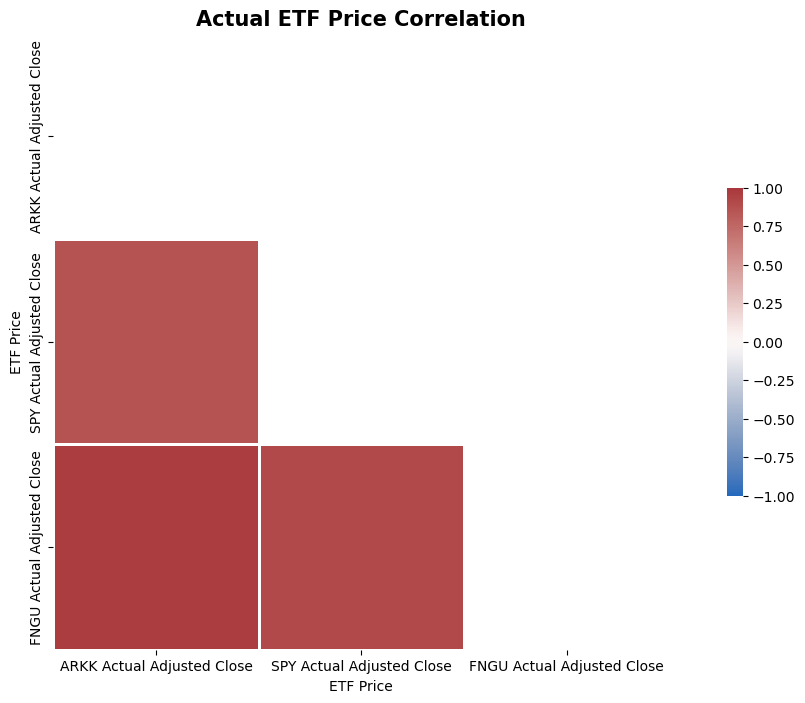

In [98]:
# Plotting heatmap of actual ETF price correlation
actual = pd.concat([arkk_actual_forecasted.iloc[:,0],spy_actual_forecasted.iloc[:,0],fngu_actual_forecasted.iloc[:,0]], join='inner', axis=1)
plotter.heatmap(actual, 'Actual')

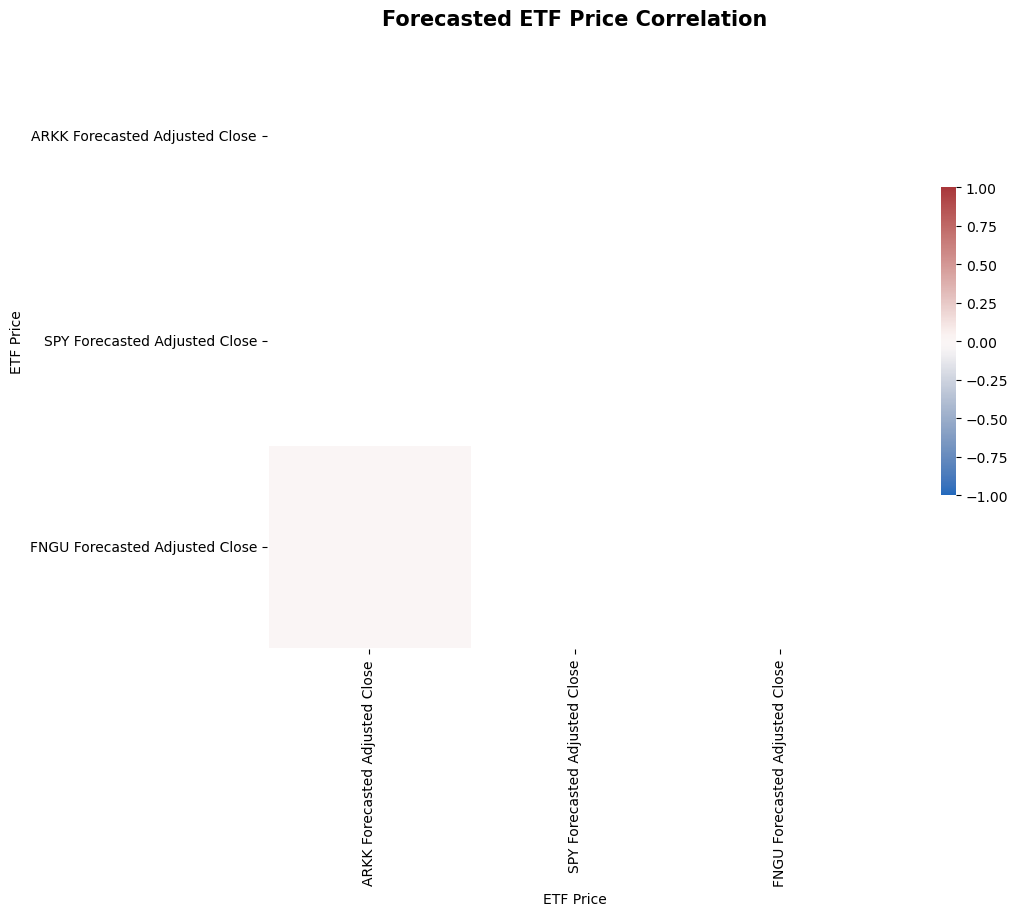

In [99]:
# Plotting heatmap of forecasted ETF price correlation
forecasted = pd.concat([arkk_actual_forecasted.iloc[:,1],spy_actual_forecasted.iloc[:,1],fngu_actual_forecasted.iloc[:,1]], join='inner', axis=1)
plotter.heatmap(forecasted, 'Forecasted')

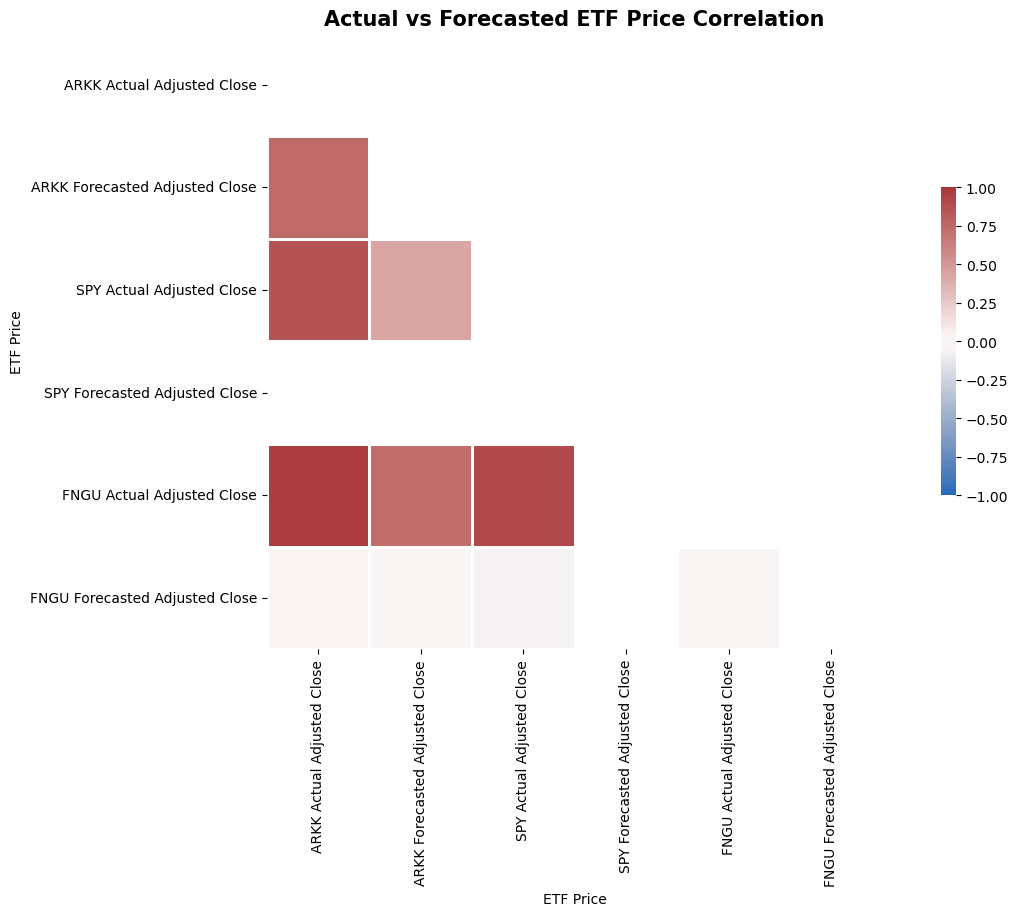

In [100]:
# Plotting heatmap of actual vs forecasted ETF price correlation
plotter.heatmap(actual_forecasted, avf)

### Training Data vs Actual vs Forecasted

In [101]:
# Creating DataFrame of training, actual and forecasted adjusted cloding prices
training_data = etf_data[:training_length].rename(columns={tickers[i]: tickers[i] + ' Training Data' for i in range(3)})
train_actual_forecasted = pd.concat([training_data,actual_forecasted])

In [102]:
# Helper method to get DataFrame by ticker
get_df_by_ticker = lambda ticker: train_actual_forecasted[[col for col in train_actual_forecasted if col.startswith(ticker)]]

In [103]:
# Variable for title and lambda helper method to get title
taf = 'Training Data vs Actual vs Forecasted'
get_train_title = lambda index: tickers[index] + ' ' + taf

In [104]:
# Saving and displaying ARKK data
arrk_train_actual_forecasted = get_df_by_ticker(tickers[0])
display_head_tail(arrk_train_actual_forecasted)

,ARKK Training Data,ARKK Actual Adjusted Close,ARKK Forecasted Adjusted Close
Date,,,
2020-03-02,52.79,NaN,NaN
2020-03-03,51.73,NaN,NaN
2020-03-04,53.49,NaN,NaN
2020-03-05,52.24,NaN,NaN
2020-03-06,50.87,NaN,NaN


,ARKK Training Data,ARKK Actual Adjusted Close,ARKK Forecasted Adjusted Close
Date,,,
2022-03-24,NaN,66.40,78.58
2022-03-25,NaN,64.51,78.00
2022-03-28,NaN,67.06,77.47
2022-03-29,NaN,71.39,76.95
2022-03-30,NaN,68.68,76.51


In [105]:
# Plotting ARKK data
plotter.line(arrk_train_actual_forecasted, get_train_title(0))

:NdOverlay   [Adjusted Close Price]
   :Curve   [Date]   (value)

In [106]:
# Saving and displaying SPY data
spy_train_actual_forecasted = get_df_by_ticker(tickers[1])
display_head_tail(spy_train_actual_forecasted)

,SPY Training Data,SPY Actual Adjusted Close,SPY Forecasted Adjusted Close
Date,,,
2020-03-02,294.65,NaN,NaN
2020-03-03,286.22,NaN,NaN
2020-03-04,298.25,NaN,NaN
2020-03-05,288.33,NaN,NaN
2020-03-06,283.57,NaN,NaN


,SPY Training Data,SPY Actual Adjusted Close,SPY Forecasted Adjusted Close
Date,,,
2022-03-24,NaN,444.68,382.03
2022-03-25,NaN,446.85,382.03
2022-03-28,NaN,450.03,382.03
2022-03-29,NaN,455.59,382.03
2022-03-30,NaN,452.78,382.03


In [107]:
# Plotting SPY data
plotter.line(spy_train_actual_forecasted, get_train_title(1))

:NdOverlay   [Adjusted Close Price]
   :Curve   [Date]   (value)

In [108]:
# Saving and displaying FNGU data
fngu_train_actual_forecasted = get_df_by_ticker(tickers[2])
display_head_tail(fngu_train_actual_forecasted)

,FNGU Training Data,FNGU Actual Adjusted Close,FNGU Forecasted Adjusted Close
Date,,,
2020-03-02,80.15,NaN,NaN
2020-03-03,73.85,NaN,NaN
2020-03-04,80.57,NaN,NaN
2020-03-05,73.80,NaN,NaN
2020-03-06,68.17,NaN,NaN


,FNGU Training Data,FNGU Actual Adjusted Close,FNGU Forecasted Adjusted Close
Date,,,
2022-03-24,NaN,236.0,300.41
2022-03-25,NaN,233.4,300.41
2022-03-28,NaN,247.0,300.41
2022-03-29,NaN,257.7,300.41
2022-03-30,NaN,247.5,300.41


In [109]:
# Plotting FNGU data
plotter.line(fngu_train_actual_forecasted, get_train_title(2))

:NdOverlay   [Adjusted Close Price]
   :Curve   [Date]   (value)

In [110]:
# Displaying ETF data
display_head_tail(train_actual_forecasted)

,ARKK Training Data,SPY Training Data,FNGU Training Data,ARKK Actual Adjusted Close,ARKK Forecasted Adjusted Close,SPY Actual Adjusted Close,SPY Forecasted Adjusted Close,FNGU Actual Adjusted Close,FNGU Forecasted Adjusted Close
Date,,,,,,,,,
2020-03-02,52.79,294.65,80.15,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-03,51.73,286.22,73.85,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-04,53.49,298.25,80.57,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-05,52.24,288.33,73.80,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-06,50.87,283.57,68.17,NaN,NaN,NaN,NaN,NaN,NaN


,ARKK Training Data,SPY Training Data,FNGU Training Data,ARKK Actual Adjusted Close,ARKK Forecasted Adjusted Close,SPY Actual Adjusted Close,SPY Forecasted Adjusted Close,FNGU Actual Adjusted Close,FNGU Forecasted Adjusted Close
Date,,,,,,,,,
2022-03-24,NaN,NaN,NaN,66.40,78.58,444.68,382.03,236.0,300.41
2022-03-25,NaN,NaN,NaN,64.51,78.00,446.85,382.03,233.4,300.41
2022-03-28,NaN,NaN,NaN,67.06,77.47,450.03,382.03,247.0,300.41
2022-03-29,NaN,NaN,NaN,71.39,76.95,455.59,382.03,257.7,300.41
2022-03-30,NaN,NaN,NaN,68.68,76.51,452.78,382.03,247.5,300.41


In [111]:
# Plotting ETF data
plotter.line(train_actual_forecasted, taf, None)

:NdOverlay   [Adjusted Close Price]
   :Curve   [Date]   (value)

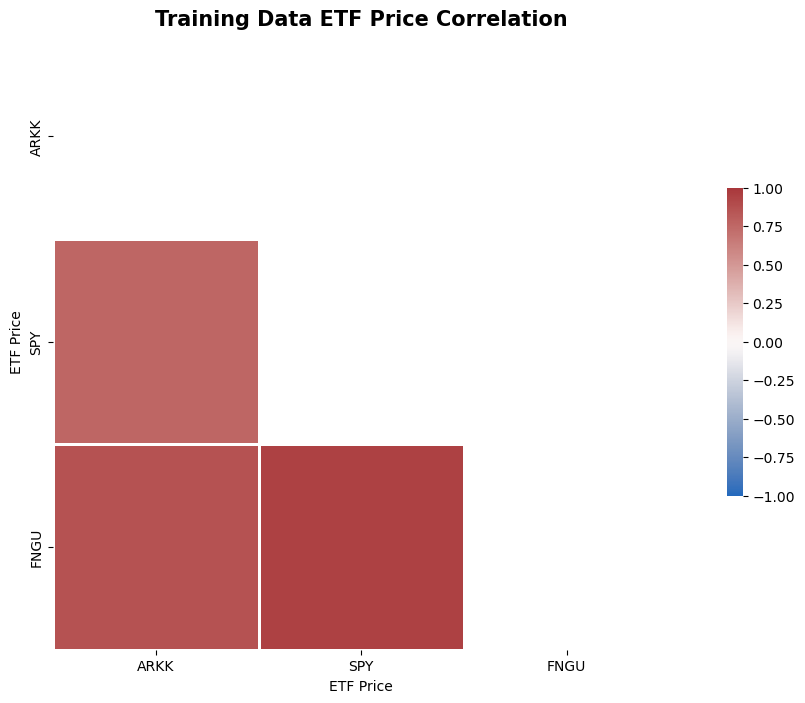

In [112]:
# Plotting ETF training data heatmap
plotter.heatmap(etf_data[:training_length], 'Training Data')

## Write-Up

## Conclusion